<font size="6"><b>Image recognition project</b></font>

<font size="4">Name: Popa Ioana-Diana</font>

<font size="4">E-mail: popaioana2015@yahoo.com</font>

## Introduction

**Purpose**

The purpose of this task is to develop a machine learning-based approach for classifying different types of surfaces: grass, sand, and stairs, using image processing techniques. By extracting meaningful features from images and applying various classification models, this study aims to evaluate the effectiveness of different machine learning algorithms in distinguishing between these surface types.

**Data Description**

The dataset consists of images of three different surfaces: grass, sand, and stairs. The images were sourced from external URLs, downloaded, and processed to ensure consistency in size and format. Each image underwent preprocessing steps including resizing, grayscale conversion, and quantization to standardize its characteristics. Feature extraction techniques were applied to derive relevant information about texture and color distribution, which were then used for classification.

**Methods**

- *Image Preprocessing*: The images were resized to a fixed dimension and converted to grayscale. To reduce noise and emphasize texture details, an 8-level quantization technique was applied.

- *Feature Extraction*: There was two types of features extracted: color-based features (Mean and variance of the RGB color channels) and texture-based features (GLCM correlation values, which capture textural patterns in the images).

- *Machine Learning Models*: Three different classifiers were trained and evaluated:
Ridge Classifier, Random Forest Classifier, Multi-Layer Perceptron Classifier.

- *Model Evaluation*: Performance was assessed using Stratified K-Fold Cross-Validation and Nested Cross-Validation to ensure robustness. Accuracy scores and confusion matrices were used to analyze the classification results.

## Data preparation

 - Import all the necessary packages for this notebook in one cell.

 - Read the URLs from text files and import the images.

 - Crop and/or resize the images to ensure they are all the same size.

 - Convert the images to grayscale and reduce the quantization level (e.g., to 8 levels) for GLCM and GLRLM analysis.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import requests
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from io import BytesIO
from PIL import Image

In [2]:
# Define the text files containing image URLs and the corresponding save directories
datasets = {
    "grass": "D:/Descarcari/grass_images_urls.txt",
    "sand": "D:/Descarcari/sand_images_urls.txt",
    "stairs": "D:/Descarcari/stairs_images_urls.txt"
}

# Create directories
for folder in datasets.keys():
    os.makedirs(folder + "_images", exist_ok=True)

In [3]:
# Function to download images from URLs
def download_images(dataset_name, url_file):
    with open(url_file, "r") as file:
        urls = file.read().splitlines()
    
    images = []
    for i, url in enumerate(urls):
        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()
            img = Image.open(BytesIO(response.content))
            images.append(img)
            img.save(f"{dataset_name}_images/{dataset_name}_{i}.jpg")
            print(f"Downloaded {dataset_name}_{i}.jpg")
        except Exception as e:
            print(f"Error downloading image {i} from {dataset_name}: {e}")
    
    return images

# Download images for all datasets
image_data = {name: download_images(name, path) for name, path in datasets.items()}

Downloaded grass_0.jpg
Downloaded grass_1.jpg
Downloaded grass_2.jpg
Downloaded grass_3.jpg
Downloaded grass_4.jpg
Downloaded grass_5.jpg
Downloaded grass_6.jpg
Downloaded grass_7.jpg
Downloaded grass_8.jpg
Downloaded grass_9.jpg
Downloaded grass_10.jpg
Downloaded grass_11.jpg
Downloaded grass_12.jpg
Downloaded grass_13.jpg
Downloaded grass_14.jpg
Downloaded grass_15.jpg
Downloaded grass_16.jpg
Downloaded grass_17.jpg
Downloaded grass_18.jpg
Downloaded grass_19.jpg
Downloaded grass_20.jpg
Downloaded grass_21.jpg
Downloaded grass_22.jpg
Downloaded grass_23.jpg
Downloaded grass_24.jpg
Downloaded grass_25.jpg
Downloaded grass_26.jpg
Downloaded grass_27.jpg
Downloaded grass_28.jpg
Downloaded grass_29.jpg
Downloaded grass_30.jpg
Downloaded grass_31.jpg
Downloaded grass_32.jpg
Downloaded grass_33.jpg
Downloaded grass_34.jpg
Downloaded grass_35.jpg
Downloaded grass_36.jpg
Downloaded grass_37.jpg
Downloaded grass_38.jpg
Downloaded grass_39.jpg
Downloaded grass_40.jpg
Downloaded grass_41.jpg
Do

In [4]:
# Define a common target size for all images
TARGET_SIZE = (256, 256)

def resize_images(images):
    return [img.resize(TARGET_SIZE, Image.LANCZOS) for img in images]

# Crop and/or resize the images (from each dataset) into same size
resized_data = {name: resize_images(images) for name, images in image_data.items()}


In [5]:
def convert_to_grayscale(images):
    return [img.convert("L") for img in images]

# Apply grayscale conversion to each dataset
grayscale_data = {name: convert_to_grayscale(images) for name, images in resized_data.items()}

In [6]:
def quantize_images(images, levels=8):
    factor = 256 // levels
    return [img.point(lambda x: (x // factor) * factor) for img in images]

# Apply quantization to grayscale images
quantized_data = {name: quantize_images(images) for name, images in grayscale_data.items()}


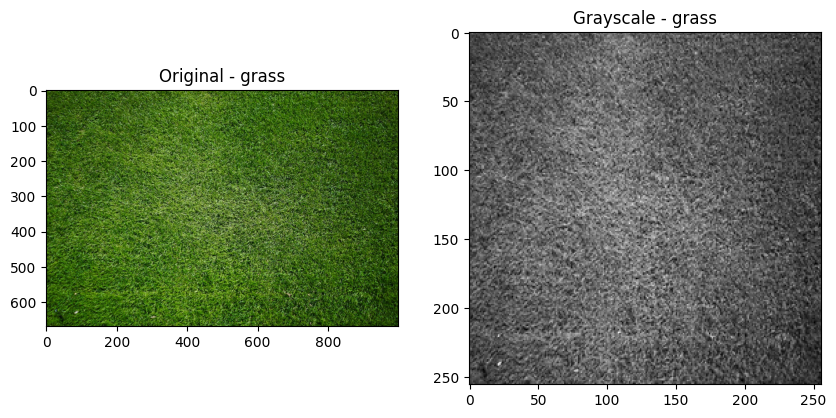

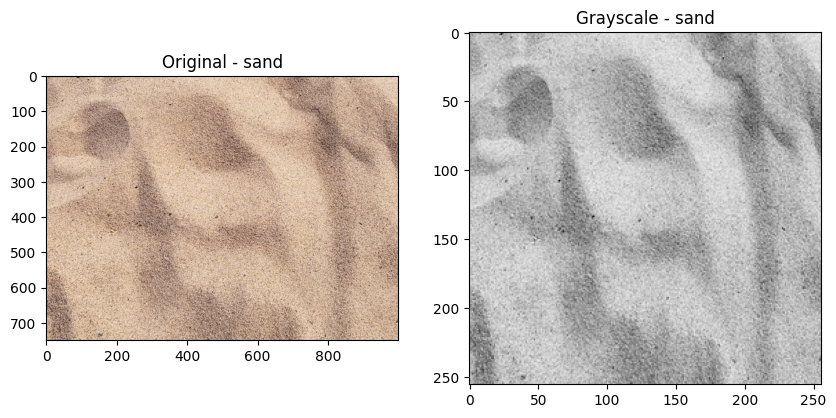

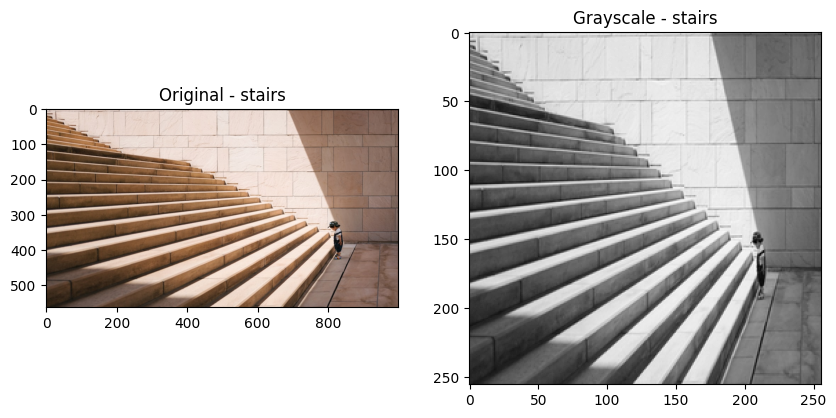

In [7]:
def show_original_and_grayscale(dataset_name):
    original = image_data[dataset_name][0]  # First image from the dataset
    grayscale = grayscale_data[dataset_name][0]  # First grayscale image

    # Create a side-by-side comparison
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Show the original image
    axes[0].imshow(original)
    axes[0].set_title(f"Original - {dataset_name}")

    # Show the grayscale image
    axes[1].imshow(grayscale, cmap="gray")
    axes[1].set_title(f"Grayscale - {dataset_name}")

    plt.show()

# Display images for each dataset
for dataset in datasets.keys():
    show_original_and_grayscale(dataset)


## Feature extraction

### First order texture measures (6 features)

  Calculate the following color features for each image:
 
 - Mean for each RGB color channel
 
 - Variance for each RGB color channel

In [8]:
# Function to calculate mean and variance for each RGB color channel
def calculate_rgb_features(image):
    img_array = np.array(image)
    
    # Calculate the mean and variance for each RGB channel
    means = img_array.mean(axis=(0, 1))  # Mean for each channel (Red, Green, Blue)
    variances = img_array.var(axis=(0, 1))  # Variance for each channel (Red, Green, Blue)
    
    return means, variances
    
# Calculate RGB features for all images in each dataset
rgb_features = {}

for name, images in resized_data.items():
    features_for_dataset = []
    for img in images:
        means, variances = calculate_rgb_features(img)
        features_for_dataset.append({"means": means, "variances": variances})
    rgb_features[name] = features_for_dataset

print(rgb_features["grass"][0]) 

{'means': array([ 65.30924988, 102.83030701,  27.01869202]), 'variances': array([613.55861561, 746.53619147, 344.99228061])}


### Second order texture measures (4 features)

Extract Gray-Level Co-Occurrence Matrix (GLCM) features (4 features) for each image:

 - Calculate the GLC matrix
 
 - Use the GLC matrix to compute the "correlation" feature
 
 - Perform this calculation in both horizontal and vertical directions for two reference pixel distances 

The choice of distances [1,2] in the Gray-Level-Co-Occurrence (GLCM) calculation is based on the need to capture different levels of texture patterns in the images. 
The distance of 1 captures fine texture details, such as small patterns, edges, and local variations in pixel intensity. It focuses on immediate pixel relationships, detecting small-scale textures that are important for differentiating surfaces like grass, sand, and stairs.
The distance of 2 helps capture slightly larger patterns in the texture, which may not be visible in immediate neighboring pixels.
If a larger distance (e.g., 5 or 10) were chosen, it might capture more global patterns but lose fine details. Thus, using distances of 1 and 2 provide a balance between local and slightly more global texture features.

In [9]:
# Function to calculate GLC matrix and "correlation" feature
def calculate_glcm_features(image, distances=[1, 2], angles=[0, np.pi/2]):
    gray_image = np.array(image.convert("L"))
    glcm = graycomatrix(gray_image, distances=distances, angles=angles, symmetric=True, normed=True)
    
    # Calculate the "correlation" feature for each direction and distance
    correlations = {}
    for angle in angles:
        for dist in distances:
            correlation = graycoprops(glcm, 'correlation')[distances.index(dist), angles.index(angle)]
            correlations[f"correlation_dist_{dist}_angle_{angle}"] = correlation
            
    return correlations

# Calculate GLC matrix features for all images in each dataset
glcm_features = {}

for name, images in resized_data.items():
    features_for_dataset = []
    for img in images:
        correlations = calculate_glcm_features(img)
        features_for_dataset.append(correlations)
    glcm_features[name] = features_for_dataset

print(glcm_features["grass"][0]) 

{'correlation_dist_1_angle_0': np.float64(0.5224998269589917), 'correlation_dist_2_angle_0': np.float64(0.3090712216388015), 'correlation_dist_1_angle_1.5707963267948966': np.float64(0.5189947275071514), 'correlation_dist_2_angle_1.5707963267948966': np.float64(0.27488285590900585)}


 - Gather the extracted features into an input array X and the image classes into an output array y.
 
 - Standardize the feature values in X.

In [10]:
# Prepare X (Feature Array) and y (Class Labels)
X = []
y = []
class_mapping = {name: idx for idx, name in enumerate(datasets.keys())} 

for name, images in resized_data.items():
    for i in range(len(images)):
        rgb_means = rgb_features[name][i]["means"]
        rgb_variances = rgb_features[name][i]["variances"]
        glcm_corrs = list(glcm_features[name][i].values())

        # Combine all features into a single vector
        feature_vector = np.hstack([rgb_means, rgb_variances, glcm_corrs])
        X.append(feature_vector)
        y.append(class_mapping[name])  # Assign corresponding class label

X = np.array(X)
y = np.array(y)

# Standardize the feature values in X
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Print shapes
print("Shape of X:", X.shape)  
print("Shape of y:", y.shape)  

print("First 5 feature vectors:\n", X[:5])

Shape of X: (185, 10)
Shape of y: (185,)
First 5 feature vectors:
 [[-1.24298019 -0.59880318 -1.50958812 -1.03592451 -0.93371671 -0.88151889
  -3.27263975 -2.97258374 -3.16820762 -2.80361111]
 [-0.09663386  0.33919668  0.48118395  0.98141756  0.68511557  1.18720959
   0.60898333  0.73930074  0.62522841  0.75425836]
 [-2.0214826  -0.92110943 -1.71773259 -1.17693574  0.32310437 -0.90670608
  -1.64204871 -2.53931369 -1.27638368 -1.93267456]
 [-0.49307826 -0.2153374  -1.59635453 -0.82052781 -0.68090237 -0.81800771
  -1.77188951 -2.04268997 -0.69060587 -1.07661041]
 [-0.34682369  0.63281264 -1.26165004 -0.15626251 -0.43425246 -0.42804881
   0.01973917 -0.10467539  0.63065063  0.66980693]]


## Feature relationships

 -Create illustrations to visualize the relationships between features.

 -Analyze and discuss the results.

### Pairplot

 - Identify feature pairs that exhibit roughly linear dependence:

The feature pairs that show a rough linear dependence in my analysis are R_mean with G_mean, B_mean with R_mean, R_var with G_var, GLCM_corr_1_0 with GLCM_corr_1_90, and GLCM_corr_2_0 with GLCM_corr_2_90. This indicates that the red, green, and blue color channels, along with certain texture features, tend to vary in a similar way across the images.

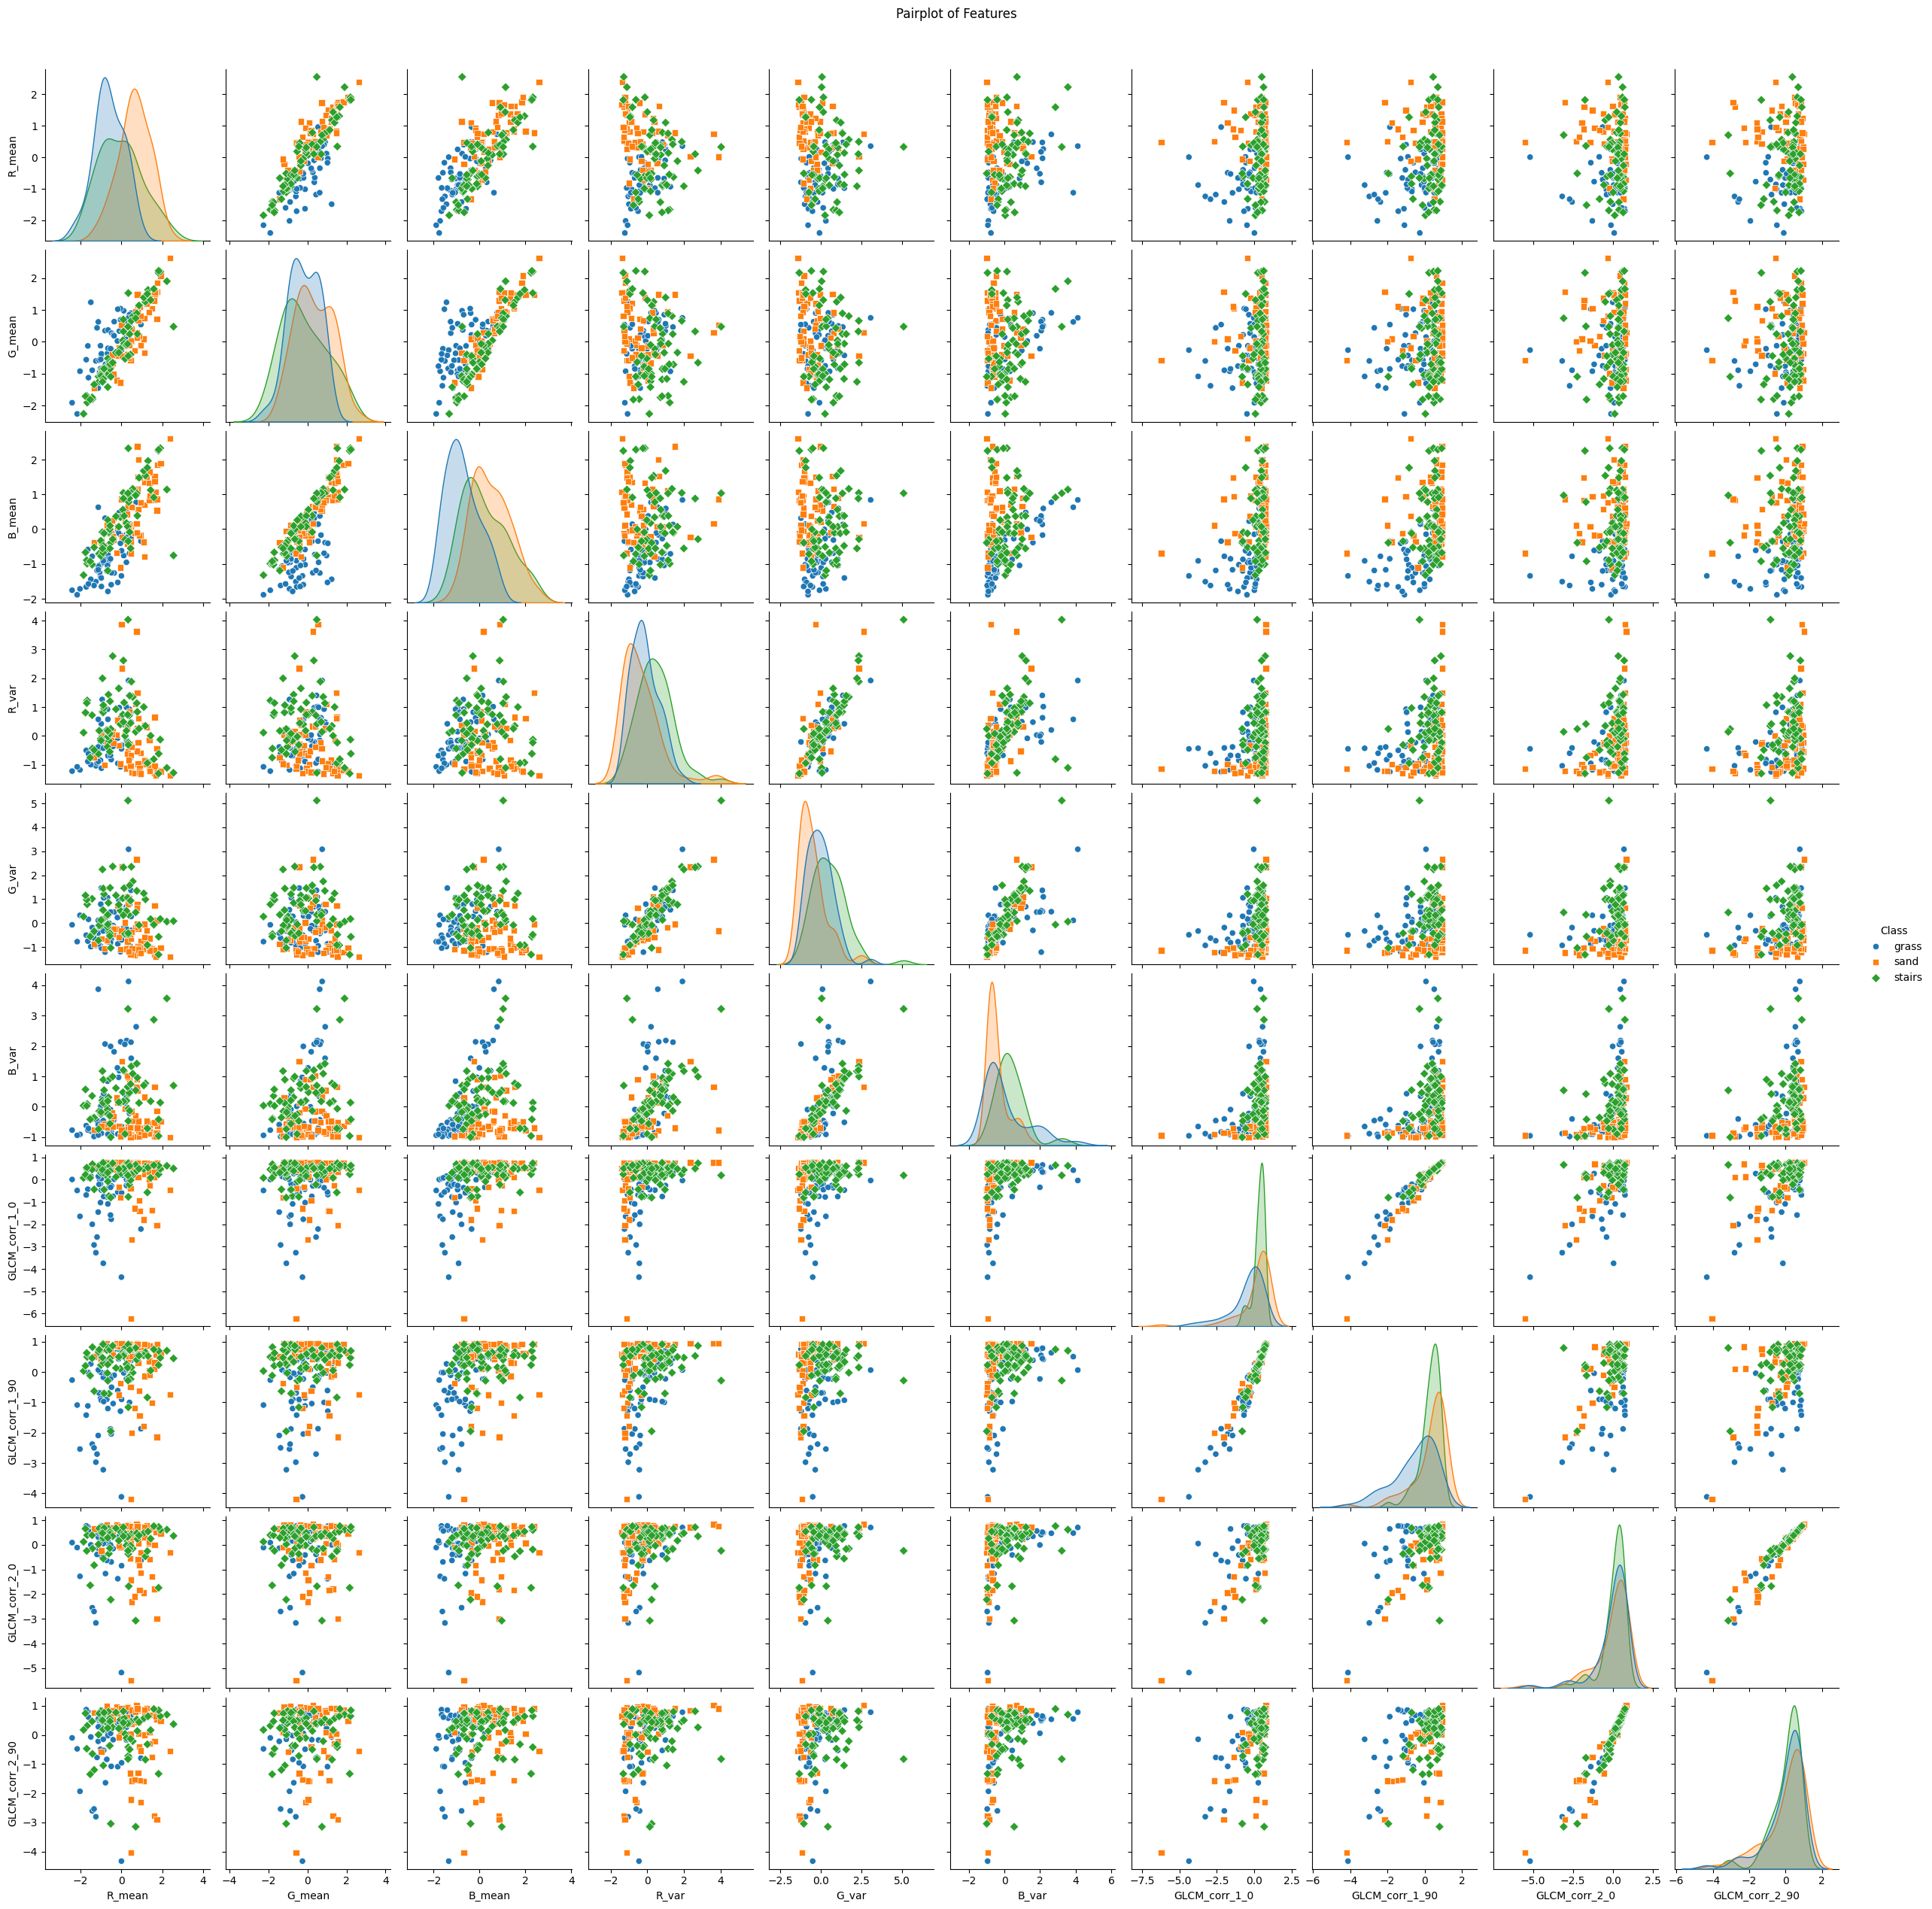

In [11]:
# Convert X to DataFrame (for better visualization)
feature_names = ['R_mean', 'G_mean', 'B_mean', 'R_var', 'G_var', 'B_var', 
                 'GLCM_corr_1_0', 'GLCM_corr_1_90', 'GLCM_corr_2_0', 'GLCM_corr_2_90']

df = pd.DataFrame(X, columns=feature_names)
df['Class'] = y  # Add class labels

# Convert class numbers back to names (for clarity)
class_labels = {idx: name for name, idx in class_mapping.items()}
df['Class'] = df['Class'].map(class_labels)

sns.pairplot(df, hue="Class", diag_kind="kde", markers=["o", "s", "D"])
plt.suptitle("Pairplot of Features", y=1.02)
plt.show()

### Histograms

 - Plot histograms for each Z-scored feature, displaying all image classes in the same figure with different colors for each.
   
 - Identify features that may have some discriminative power over image classes based on the histograms.

From my analysis, B_mean, GLCM_corr_1_0, and GLCM_corr_1_90 appear to have some discriminative power. While none of these features perfectly separate the classes, they show a degree of distinction. B_mean helps differentiate between 'grass' and 'sand', while GLCM_corr_1_0 and GLCM_corr_1_90 seem to better separate 'grass' from the other two classes, though some overlap remains.

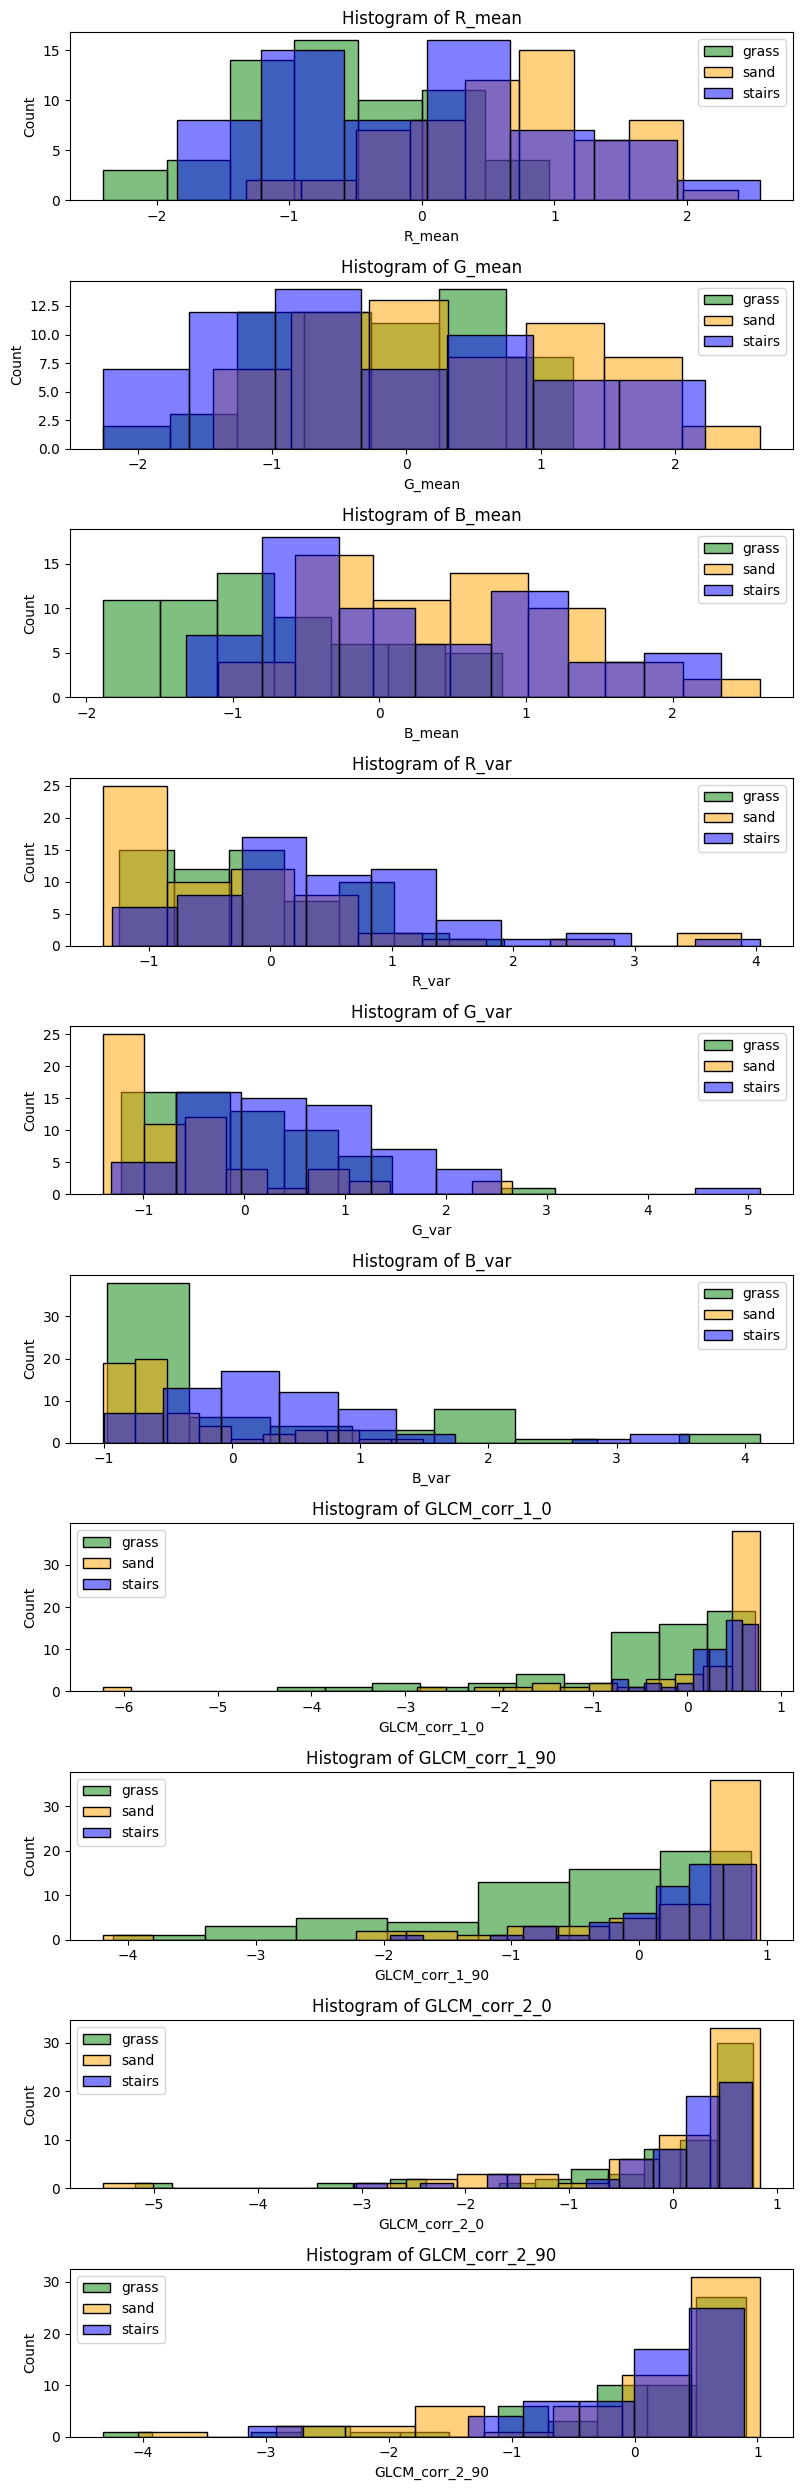

In [12]:
fig, axes = plt.subplots(len(feature_names), 1, figsize=(8, 25))
colors = {"grass": "green", "sand": "orange", "stairs": "blue"}

for i, feature in enumerate(feature_names):
    for class_name in class_labels.values():
        sns.histplot(df[df["Class"] == class_name][feature], 
                     label=class_name, ax=axes[i], color=colors[class_name], alpha=0.5)
    
    axes[i].set_title(f"Histogram of {feature}")
    axes[i].legend()

plt.tight_layout()
plt.show()

### PCA

 - Perform PCA and visualize the image classes using different colors.

 - Analyze whether clusters are visible in the PCA plot.

The PCA scatterplot doesn’t reveal clear clusters for the three image types (grass, sand, and stairs). Instead, data points from all classes are mixed together, indicating that the extracted features don’t naturally separate the categories. Due to this overlap, classifying the images accurately might be challenging, as there’s no obvious distinction between them in this reduced two-dimensional space.

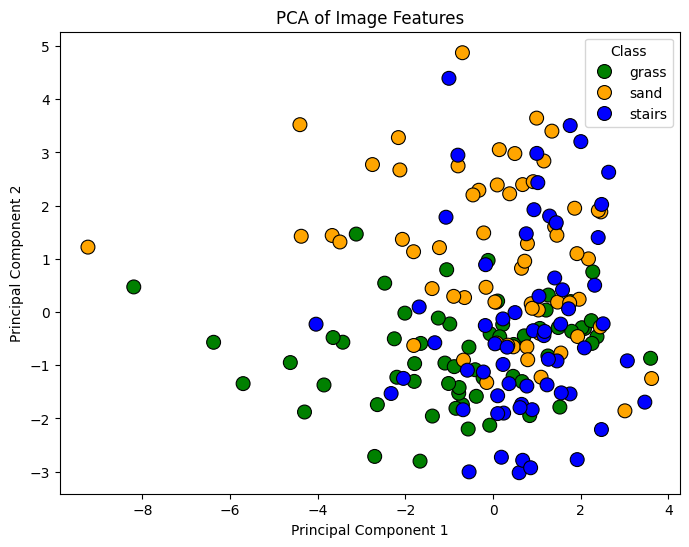

In [13]:
# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

pca_df = pd.DataFrame(X_pca, columns=["PCA1", "PCA2"])
pca_df['Class'] = df['Class']

# Plotting the PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PCA1", y="PCA2", hue="Class", palette=colors, s=100, edgecolor="black")
plt.title("PCA of Image Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Class")
plt.show()

## Build classifiers and select the best hyperparameters with cross validation

I perform model selection for each classifier using 5-fold stratified cross-validation (StratifiedKFold and GridSearchCV from sklearn). I tune the models using the following hyperparameters:

 1. Ridge Classifier:

 - Strength of the regularization term: alpha = [0.001, 0.01, 0.1, 1.0]

 2. Random Forest:

 - n_estimators ranging from 100 to 300 with 50 steps
 - max_features = ['sqrt', 'log2', None]
 - Whether to use bootstrap or not
 
 3. MLP:

 - One hidden layer
 - Number of neurons in the hidden layer from 15 to 40 in 5-neuron steps
 - Activation function: hyperbolic tanh function and rectified linear unit function
 - Solver: stochastic gradient descent and adam
 - Validation_fraction: 0.1 and 0.3
 - Strength of the L2 regularization term: alpha = [0.01, 0.1, 1]

For each classifier, I:

 - Report the selected combination of hyperparameters.
 - Report the accuracy value for each hyperparameter combination.
 - For the Random Forest model, I also report the feature importance for each feature.

In [14]:
# Define Stratified K-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2004)

# Ridge Classifier
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1.0]}
ridge = GridSearchCV(RidgeClassifier(), ridge_params, cv=cv, scoring='accuracy', return_train_score=True)
ridge.fit(X, y)
ridge_results = pd.DataFrame(ridge.cv_results_)

ridge_results_sorted = ridge_results[['params', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False)

print("Best Ridge Params:", ridge.best_params_)
print("Ridge Classifier Results (Sorted by Accuracy):\n", ridge_results_sorted)

Best Ridge Params: {'alpha': 1.0}
Ridge Classifier Results (Sorted by Accuracy):
              params  mean_test_score
3    {'alpha': 1.0}         0.800000
2    {'alpha': 0.1}         0.794595
1   {'alpha': 0.01}         0.789189
0  {'alpha': 0.001}         0.789189


In [15]:
# Random Forest
rf_params = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}
rf = GridSearchCV(RandomForestClassifier(random_state=2004), rf_params, cv=cv, scoring='accuracy', return_train_score=True)
rf.fit(X, y)
rf_results = pd.DataFrame(rf.cv_results_)

rf_results_sorted = rf_results[['params', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False)

print("Best Random Forest Params:", rf.best_params_)
print("Random Forest Results (Sorted by Accuracy):\n", rf_results_sorted)

# Feature Importance from best Random Forest Model
best_rf = rf.best_estimator_
feature_importances = pd.Series(best_rf.feature_importances_, index=['R_mean', 'G_mean', 'B_mean', 'R_var', 'G_var', 'B_var',
                                                                     'GLCM_corr_1_0', 'GLCM_corr_1_90', 'GLCM_corr_2_0', 'GLCM_corr_2_90'])
print("Feature Importances (Sorted):\n", feature_importances.sort_values(ascending=False))

Best Random Forest Params: {'bootstrap': True, 'max_features': None, 'n_estimators': 150}
Random Forest Results (Sorted by Accuracy):
                                                params  mean_test_score
11  {'bootstrap': True, 'max_features': None, 'n_e...         0.778378
4   {'bootstrap': True, 'max_features': 'sqrt', 'n...         0.772973
9   {'bootstrap': True, 'max_features': 'log2', 'n...         0.772973
13  {'bootstrap': True, 'max_features': None, 'n_e...         0.772973
8   {'bootstrap': True, 'max_features': 'log2', 'n...         0.772973
3   {'bootstrap': True, 'max_features': 'sqrt', 'n...         0.772973
10  {'bootstrap': True, 'max_features': None, 'n_e...         0.762162
12  {'bootstrap': True, 'max_features': None, 'n_e...         0.756757
14  {'bootstrap': True, 'max_features': None, 'n_e...         0.756757
1   {'bootstrap': True, 'max_features': 'sqrt', 'n...         0.751351
6   {'bootstrap': True, 'max_features': 'log2', 'n...         0.751351
7   {'bootstr

 - Analyze which features seem to be the most important.
 - Compare the results with my observations from data exploration.

From my analysis, the Random Forest model confirms many of my initial observations during data exploration. B_mean emerges as the most important feature (22.0%), which aligns with my earlier finding that it helps differentiate grass from sand. Similarly, GLCM_corr_1_90 (10.1%) and GLCM_corr_1_0 (8.3%) play a significant role, reinforcing my observation that they help distinguish grass from the other classes.

One surprising insight is the importance of B_var (18.7%)—I hadn’t highlighted it before, but the model suggests that variations in blue intensity are quite relevant. Features like R_mean, G_var, and G_mean also contribute, even though they weren’t as obvious in my initial analysis.

Overall, my observations were quite accurate, and the model provides additional insight, confirming that both the mean and variance of color channels play a role in distinguishing the images.

In [16]:
# MLP Classifier
mlp_params = {
    'hidden_layer_sizes': [(n,) for n in range(15, 45, 5)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.01, 0.1, 1],
    'validation_fraction': [0.1, 0.3]
}
mlp = GridSearchCV(MLPClassifier(max_iter=3000, random_state=2004), mlp_params, cv=cv, scoring='accuracy', return_train_score=True)
mlp.fit(X, y)
mlp_results = pd.DataFrame(mlp.cv_results_)

mlp_results_sorted = mlp_results[['params', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False)

print("Best MLP Params:", mlp.best_params_)
print("MLP Classifier Results (Sorted by Accuracy):\n", mlp_results_sorted)

Best MLP Params: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (40,), 'solver': 'adam', 'validation_fraction': 0.1}
MLP Classifier Results (Sorted by Accuracy):
                                                params  mean_test_score
23  {'activation': 'tanh', 'alpha': 0.01, 'hidden_...         0.854054
22  {'activation': 'tanh', 'alpha': 0.01, 'hidden_...         0.854054
51  {'activation': 'tanh', 'alpha': 1, 'hidden_lay...         0.848649
50  {'activation': 'tanh', 'alpha': 1, 'hidden_lay...         0.848649
47  {'activation': 'tanh', 'alpha': 0.1, 'hidden_l...         0.837838
..                                                ...              ...
65  {'activation': 'tanh', 'alpha': 1, 'hidden_lay...         0.762162
61  {'activation': 'tanh', 'alpha': 1, 'hidden_lay...         0.756757
60  {'activation': 'tanh', 'alpha': 1, 'hidden_lay...         0.756757
36  {'activation': 'tanh', 'alpha': 0.1, 'hidden_l...         0.756757
37  {'activation': 'tanh', 'alpha': 0.1, 'h

## Estimate the performance of the models with nested cross-validation

Estimate the performance of each model using nested cross-validation.
 - Use 4-fold Stratified KFold cross-validation for the inner loop with the same parameter ranges as before.
 - Use 5-fold Stratified KFold cross-validation for the outer loop.

For each classifier (Ridge Classifier, Random Forest, MLP):
 - Report the selected combination of hyperparameters and the accuracy value for the best combination.
 - Generate a confusion matrix of the results.
 - Calculate the mean accuracy of the outer rounds in nested cross-validation and interpret its significance.

In my analysis, the mean accuracy of the outer rounds represents the average performance of the model when tested on completely unseen data. Since each outer fold acts as a final test set while the inner folds handle hyperparameter tuning, this mean accuracy provides the most unbiased estimate of how well the model will generalize in real-world scenarios. A higher mean accuracy indicates that the model consistently performs well across different data splits, while a lower accuracy or high variation suggests sensitivity to the training data.

From my results:
 - MLP Classifier (83.24%) performed the best, effectively capturing complex patterns.
 - Ridge Classifier (80.00%) followed closely, showing solid and reliable performance.
 - Random Forest (74.05%) had the most variation across folds, indicating it was more sensitive to the training data.

Ridge Classifier Nested Cross-Validation:
Best Parameters for this fold: {'alpha': 0.001}
Confusion Matrix for this fold:
[[11  0  2]
 [ 0  9  3]
 [ 0  4  8]]
Accuracy for this fold: 0.7568

Best Parameters for this fold: {'alpha': 0.001}
Confusion Matrix for this fold:
[[11  1  1]
 [ 0 11  1]
 [ 2  2  8]]
Accuracy for this fold: 0.8108

Best Parameters for this fold: {'alpha': 1.0}
Confusion Matrix for this fold:
[[12  0  0]
 [ 0 11  2]
 [ 0  3  9]]
Accuracy for this fold: 0.8649

Best Parameters for this fold: {'alpha': 1.0}
Confusion Matrix for this fold:
[[ 9  1  2]
 [ 0  7  5]
 [ 0  1 12]]
Accuracy for this fold: 0.7568

Best Parameters for this fold: {'alpha': 1.0}
Confusion Matrix for this fold:
[[10  1  1]
 [ 0 10  2]
 [ 0  3 10]]
Accuracy for this fold: 0.8108

Mean Accuracy of the outer loop: 0.8000

Random Forest Classifier Nested Cross-Validation:
Best Parameters for this fold: {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 100}
Confusion Matrix for this fold:


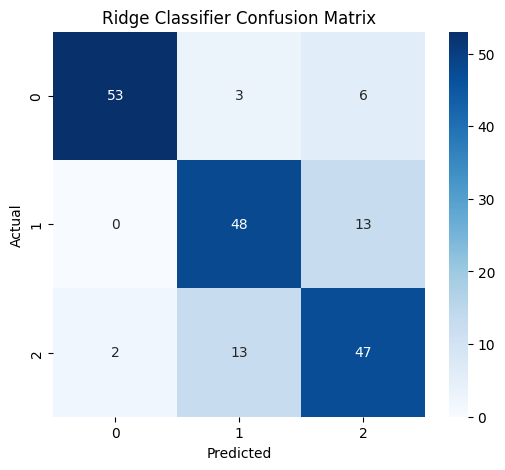

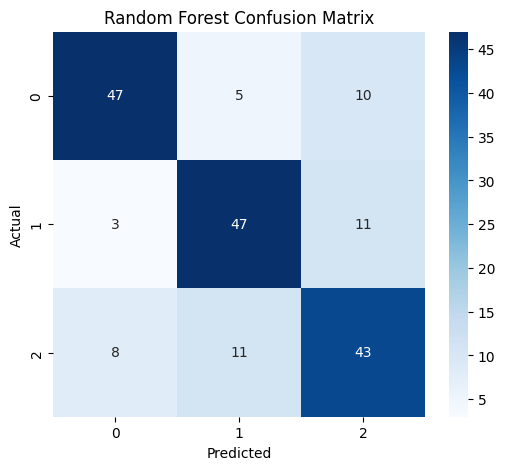

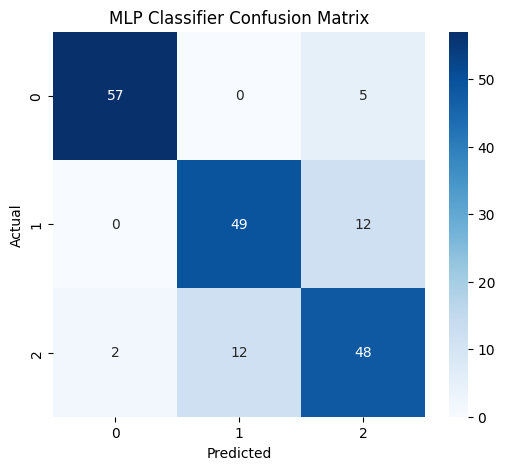

In [19]:
y = np.array(y, dtype=int)

# 4-fold Stratified K-Fold for the inner loop
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=2004)

# 5-fold Stratified K-Fold for the outer loop 
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2004)

# Function to perform nested cross-validation and compute the confusion matrix of the results
def nested_cross_validation(model, param_grid, X, y, inner_cv, outer_cv):
    total_conf_matrix = np.zeros((len(np.unique(y)), len(np.unique(y))))  # Initialize confusion matrix
    outer_results = []  # Store accuracy results

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        grid_search = GridSearchCV(estimator=clone(model), param_grid=param_grid, 
                                   cv=inner_cv, scoring='accuracy')
        grid_search.fit(X_train, y_train)

        # Get best model and make predictions
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        
        # Update the total confusion matrix
        total_conf_matrix += confusion_matrix(y_test, y_pred)
        
        # Store accuracy
        accuracy = accuracy_score(y_test, y_pred)
        outer_results.append(accuracy)
        
        # Print best parameters, confusion matrix, and accuracy for the fold
        print(f"Best Parameters for this fold: {grid_search.best_params_}")
        print(f"Confusion Matrix for this fold:\n{confusion_matrix(y_test, y_pred)}")
        print(f"Accuracy for this fold: {accuracy:.4f}\n")
    
    # Compute and print mean accuracy
    mean_accuracy = np.mean(outer_results)
    print(f"Mean Accuracy of the outer loop: {mean_accuracy:.4f}\n")
    
    return mean_accuracy, total_conf_matrix

# Ridge Classifier
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1.0]}
print("Ridge Classifier Nested Cross-Validation:")
ridge_accuracy, ridge_conf_matrix = nested_cross_validation(RidgeClassifier(), ridge_params, X, y, inner_cv, outer_cv)

# Random Forest
rf_params = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}
print("Random Forest Classifier Nested Cross-Validation:")
rf_accuracy, rf_conf_matrix = nested_cross_validation(RandomForestClassifier(random_state=2004), rf_params, X, y, inner_cv, outer_cv)

# MLP Classifier
mlp_params = {
    'hidden_layer_sizes': [(n,) for n in range(15, 45, 5)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.01, 0.1, 1],
    'validation_fraction': [0.1, 0.3]
}
print("MLP Classifier Nested Cross-Validation:")
mlp_accuracy, mlp_conf_matrix = nested_cross_validation(MLPClassifier(max_iter=3000, random_state=2004), mlp_params, X, y, inner_cv, outer_cv)

def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

plot_confusion_matrix(ridge_conf_matrix, "Ridge Classifier Confusion Matrix")
plot_confusion_matrix(rf_conf_matrix, "Random Forest Confusion Matrix")
plot_confusion_matrix(mlp_conf_matrix, "MLP Classifier Confusion Matrix")

## Discussion

**Discussion of Results**
1. **Which model performs the best?**

Based on my nested cross-validation results, the MLP Classifier achieved the highest mean accuracy of 0.8324, outperforming both the Ridge Classifier (0.8000) and the Random Forest Classifier (0.7405).

MLP's superior performance is likely due to its ability to learn complex non-linear relationships in the data. With a single hidden layer, it captures intricate patterns more effectively than the Ridge Classifier, which is a linear model, or Random Forest, which, while powerful, is still limited by the structure of decision trees.

2. **Limitations**
 - Ridge Classifier:
     - Since it's a linear model, it may struggle with capturing non-linear relationships in the data.
     - Its performance heavily depends on choosing the right regularization parameter (alpha)—too small or too large a value can impact accuracy.
       
 - Random Forest:
     - Overfitting can occur, especially when there are too many trees or when certain features are highly correlated.
     - The variation in accuracy between folds suggests that the model might be sensitive to training data and hyperparameter choices.

 - MLP Classifier:
     - Computationally expensive, especially with larger datasets or complex architectures.
     - Requires careful hyperparameter tuning, as improper tuning may lead to overfitting or underfitting.
 
 3. **How could the results be improved?**
 - Data augmentation could artificially increase the dataset size, helping the model generalize better.
 - Extracting more advanced texture or color-related features might enhance model performance.
 - Instead of grid search, using more advanced optimization techniques like Bayesian optimization or random search could improve hyperparameter tuning efficiency.
 - Increasing the number of cross-validation folds may provide a more stable estimate of model performance.
 - Ensuring the dataset is well-balanced in terms of class distribution can reduce bias and improve generalization.
 - For MLP, applying dropout or early stopping could prevent overfitting and enhance performance on unseen data.
 - For Random Forest, techniques like pruning could help reduce overfitting and improve generalization.